In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d minhhuy2810/rice-diseases-image-dataset

100% 12.0G/12.0G [01:21<00:00, 173MB/s]
100% 12.0G/12.0G [01:21<00:00, 157MB/s]


In [3]:
import zipfile

# Extract zip
local_zip = '/content/rice-diseases-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/rice-diseases-image-dataset')
zip_ref.close()

Import neccessary packages

In [4]:
import os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [96]:
EPOCHS = 30
LEARNING_RATE = 1e-3
BS = 32
DATA_DIR = '/content/rice-diseases-image-dataset'
LABELLED_DIR = '/content/rice-diseases-image-dataset/LabelledRice/Labelled'
TRAINING_DIR = '/content/rice-diseases-image-dataset/RiceDiseaseDataset/train'
VALIDATION_DIR = '/content/rice-diseases-image-dataset/RiceDiseaseDataset/validation'
width = 256
height = 256
depth = 3

In [6]:
for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(subdir, file))

In [10]:
# From A Single Image Folder
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    LABELLED_DIR,
    target_size=(width, height),
    batch_size=BS,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    LABELLED_DIR,
    target_size=(width, height),
    batch_size=BS,
    subset='validation'
)

Found 2686 images belonging to 4 classes.
Found 669 images belonging to 4 classes.


In [8]:
# # From Separated Training & Validation Folder
# training_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=30,
#     width_shift_range=0.15,
#     height_shift_range=0.15,
#     shear_range=0.15,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# validation_datagen = ImageDataGenerator(
#     rescale=1./255,
# )

# train_generator = training_datagen.flow_from_directory(
#     TRAINING_DIR,
#     target_size=(width, height),
#     batch_size=BS,
#     class_mode='categorical'
# )

# validation_generator = validation_datagen.flow_from_directory(
#     VALIDATION_DIR,
#     target_size=(width, height),
#     batch_size=BS,
#     class_mode='categorical'
# )

Found 1600 images belonging to 4 classes.
Found 492 images belonging to 4 classes.


In [11]:
input_shape = (height, width, depth)
chan_dim = -1
n_classes = len(os.listdir(TRAINING_DIR))
if K.image_data_format() == 'channels_first':
    input_shape = (depth, height, width)
    chan_dim = 1

In [ ]:
# # Regular Learning
# model = Sequential([
#     Conv2D(32, (3, 3), padding="same",input_shape=input_shape),
#     Activation("relu"),
#     BatchNormalization(axis=chan_dim),
#     MaxPooling2D(pool_size=(3, 3)),
#     Dropout(0.25),
#     Conv2D(64, (3, 3), padding="same"),
#     Activation("relu"),
#     BatchNormalization(axis=chan_dim),
#     Conv2D(64, (3, 3), padding="same"),
#     Activation("relu"),
#     BatchNormalization(axis=chan_dim),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Conv2D(128, (3, 3), padding="same"),
#     Activation("relu"),
#     BatchNormalization(axis=chan_dim),
#     Conv2D(128, (3, 3), padding="same"),
#     Activation("relu"),
#     BatchNormalization(axis=chan_dim),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(1024),
#     Activation("relu"),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(n_classes),
#     Activation("softmax")
# ])

In [12]:
# Transfer Learning
pre_trained_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
)
pre_trained_model.trainable = False

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
# # Include destructured pretrained model
# inputs = pre_trained_model.input
# x = Dense(64, activation='relu')(pre_trained_model.output)
# outputs = Dense(n_classes, activation='softmax')(x)
# model = Model(inputs=inputs, outputs=outputs)
# model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [11]:
# # No additional Input layer
# inputs = pre_trained_model.input
# x = pre_trained_model(inputs, training=False)
# x = Dense(64, activation='relu')(x)
# outputs = Dense(n_classes, activation='softmax')(x)
# model = Model(inputs=inputs, outputs=outputs)
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 64)                122944    
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 18,445,188
Trainable params: 123,204
Non-trainable params: 18,321,984
_________________________________________________________________


In [97]:
# With additional Input layer
inputs = Input(shape=input_shape)
x = pre_trained_model(inputs, training=False)
x = Dropout(0.2)(x)
outputs = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dropout_10 (Dropout)        (None, 1920)              0         
                                                                 
 dense_11 (Dense)            (None, 4)                 7684      
                                                                 
Total params: 18,329,668
Trainable params: 7,684
Non-trainable params: 18,321,984
_________________________________________________________________


In [19]:
# # Sequential with additional Input layer
# model = Sequential([
#   Input(shape=input_shape),
#   pre_trained_model,
#   Dropout(0.2),
#   Dense(n_classes, activation='softmax')
# ])
# model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dropout_4 (Dropout)         (None, 1920)              0         
                                                                 
 dense_5 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18,329,668
Trainable params: 7,684
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
# # Sequential
# model = Sequential([
#   pre_trained_model,
#   Dense(64, activation='relu'),
#   Dense(n_classes, activation='softmax')
# ])
# model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_38 (Dense)            (None, 64)                122944    
                                                                 
 dense_39 (Dense)            (None, 4)                 260       
                                                                 
Total params: 18,445,188
Trainable params: 123,204
Non-trainable params: 18,321,984
_________________________________________________________________


Model Summary

In [98]:
# optimizer = Adam(learning_rate=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

BEST_MODEL = 'saved_model/best_model'
BEST_MODEL_H5 = BEST_MODEL + '.h5'

def get_model_checkpoint(metrics_values={}):
    evaluated_metrics = lambda logs: [(logs[key] > val) if 'accuracy' in key else logs[key] < val for key, val in metrics_values.items()]

    class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):
        def on_epoch_end(self, epoch, logs):
            if False not in evaluated_metrics(logs):
                super().on_epoch_end(epoch, logs)
                global best_model
                best_model = self.model

    return MyModelCheckpoint(
        BEST_MODEL_H5,
        verbose=1,
        save_best_only=True,
        monitor=metrics_values.keys() if metrics_values.keys() else 'val_loss')


In [99]:
# learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: LEARNING_RATE * 10**(epoch/2)
# )

In [100]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[get_model_checkpoint({'val_loss': 0.9})],
    # callbacks=[learning_rate_schedule]
)

Epoch 1/10
84/84 [==============================] - 402s 5s/step - loss: 1.1898 - accuracy: 0.4821 - val_loss: 1.1428 - val_accuracy: 0.5127 - lr: 0.0010
Epoch 2/10
84/84 [==============================] - 385s 5s/step - loss: 0.9520 - accuracy: 0.6158 - val_loss: 1.3563 - val_accuracy: 0.3976 - lr: 0.0032
Epoch 3/10
84/84 [==============================] - 384s 5s/step - loss: 0.9815 - accuracy: 0.6102 - val_loss: 1.2937 - val_accuracy: 0.4918 - lr: 0.0100
Epoch 4/10
84/84 [==============================] - 384s 5s/step - loss: 1.7931 - accuracy: 0.5484 - val_loss: 3.4270 - val_accuracy: 0.3677 - lr: 0.0316
Epoch 5/10
84/84 [==============================] - 383s 5s/step - loss: 4.3663 - accuracy: 0.5324 - val_loss: 5.9192 - val_accuracy: 0.4694 - lr: 0.1000
Epoch 6/10
84/84 [==============================] - 384s 5s/step - loss: 15.8981 - accuracy: 0.5007 - val_loss: 15.8215 - val_accuracy: 0.5172 - lr: 0.3162
Epoch 7/10
84/84 [==============================] - 389s 5s/step - loss: 4

Plot the train and val curve

(0.001, 1.0, 0.0, 1.5)

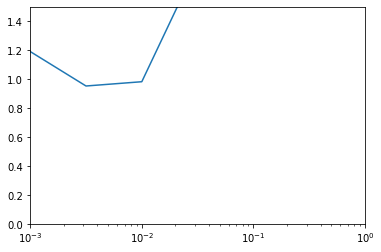

In [101]:
# plt.semilogx(history.history['lr'], history.history['loss'])
# plt.axis([LEARNING_RATE, 1e-0, 0, 1.5])

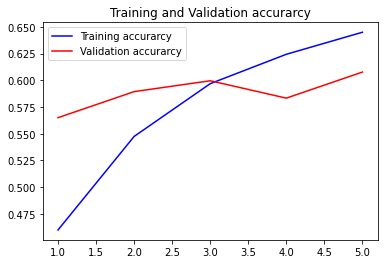

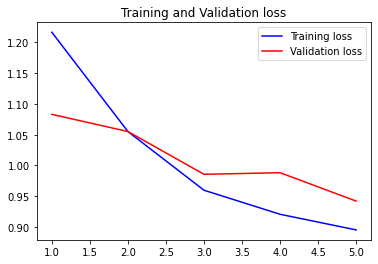

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

16/16 [==============================] - 49s 3s/step - loss: 0.9421 - accuracy: 0.6077
Test Accuracy: 60.7723593711853


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(BEST_MODEL_H5)
scores = best_model.evaluate(validation_generator)
print(f"Best Accuracy: {scores[1]*100}")

16/16 [==============================] - 49s 3s/step - loss: 0.9421 - accuracy: 0.6077
Best Accuracy: 60.7723593711853


In [ ]:
best_model.save('/content/saved_model/model')
!zip -r /content/model.zip /content/saved_model/model

INFO:tensorflow:Assets written to: /content/saved_model/model/assets
  adding: content/saved_model/model/ (stored 0%)
  adding: content/saved_model/model/assets/ (stored 0%)
  adding: content/saved_model/model/variables/ (stored 0%)
  adding: content/saved_model/model/variables/variables.index (deflated 79%)
  adding: content/saved_model/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/model/saved_model.pb (deflated 92%)
  adding: content/saved_model/model/keras_metadata.pb (deflated 97%)
